Uma API que faz consultas de cadastro de CPF: https://infosimples.com/

O custo por consulta de CPF é de R$ 0,24.

De acordo com o banco de dados fornecido (Versão V1), estima-se a presença de 5.732 idosos cadastrados, conforme demonstrado na imagem abaixo:

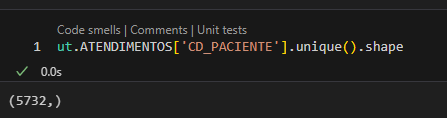

Portanto, o investimento necessário para realizar a verificação utilizando a API em questão de todos os registros será de R$ 1.375,68.

Exemplo de consulta

In [ ]:
import requests

# Configuração da URL e do token
url = "https://api.infosimples.com/api/v2/consultas/receita-federal/cpf"
headers = {
    "Content-Type": "application/json"
}
payload = {
    "token": "TOKEM_AQUI",
    "cpf": "CPF",
    "birthdate": "DATA_NASCIMENTO",
    "timeout": 30
}

# Enviar requisição POST
response = requests.post(url, json=payload, headers=headers)

# Verificar a resposta
if response.status_code == 200:
    print(response.json())
else:
    print(f"Erro: {response.status_code}, {response.text}")

{'code': 200, 'code_message': 'A requisição foi processada com sucesso.', 'header': {'api_version': 'v2', 'api_version_full': '2.2.22-20241121122401', 'product': 'Consultas', 'service': 'receita-federal/cpf', 'parameters': {'birthdate': '2000-10-26', 'cpf': '07837686306'}, 'client_name': 'Allan Pereira Fenelon', 'token_name': 'Allan Pereira Fenelon', 'billable': True, 'price': '0.24', 'requested_at': '2024-11-21T15:30:17.000-03:00', 'elapsed_time_in_milliseconds': 1796, 'remote_ip': '143.0.209.51', 'signature': 'U2FsdGVkX1//OUMFi3VNxSZXz3NW/rvKmzKEzt61AhLpzF8q1KD1LpQbJVxFH/MVocdeqxIRHmAMt38NIvSZCg=='}, 'data_count': 1, 'data': [{'ano_obito': None, 'consulta_comprovante': 'DF00.ADAA.5E0A.D463', 'consulta_datahora': '21/11/2024 15:30:16', 'consulta_digito_verificador': '00', 'cpf': '078.376.863-06', 'data_inscricao': '26/11/2014', 'data_nascimento': '26/10/2000', 'nome': 'ALLAN PEREIRA FENELON', 'nome_civil': '', 'nome_social': '', 'normalizado_ano_obito': 0, 'normalizado_consulta_dataho

In [14]:
import pandas as pd

In [16]:
dados = pd.DataFrame(response.json()['data'])

In [19]:
dados.columns

Index(['ano_obito', 'consulta_comprovante', 'consulta_datahora',
       'consulta_digito_verificador', 'cpf', 'data_inscricao',
       'data_nascimento', 'nome', 'nome_civil', 'nome_social',
       'normalizado_ano_obito', 'normalizado_consulta_datahora',
       'normalizado_cpf', 'normalizado_data_inscricao',
       'normalizado_data_nascimento', 'origem', 'qrcode_url',
       'situacao_cadastral', 'site_receipt'],
      dtype='object')

O sistema retorna o ano de óbito e a situação cadastral, informações essenciais para determinar se o paciente oncológico está vivo ou falecido.

In [23]:
dados

,ano_obito,consulta_comprovante,consulta_datahora,consulta_digito_verificador,cpf,data_inscricao,data_nascimento,nome,nome_civil,nome_social,normalizado_ano_obito,normalizado_consulta_datahora,normalizado_cpf,normalizado_data_inscricao,normalizado_data_nascimento,origem,qrcode_url,situacao_cadastral,site_receipt
0,None,DF00.ADAA.5E0A.D463,21/11/2024 15:30:16,00,078.376.863-06,26/11/2014,26/10/2000,ALLAN PEREIRA FENELON,,,0,21/11/2024 15:30:16,07837686306,26/11/2014,26/10/2000,web,https://servicos.receita.fazenda.gov.br/Servic...,REGULAR,https://us-central1-infosimples-data.cloudfunc...


Com essa automação, é possível atualizar o banco de dados de forma rápida e eficaz, garantindo maior agilidade no processo.

Observação: Recomenda-se não excluir os registros de pacientes falecidos do banco de dados hospitalar. Em vez disso, sugere-se a criação de uma coluna adicional indicando o status de vida do paciente, onde o valor seria True para os vivos e False para os falecidos. Essa abordagem mantém o histórico completo e facilita análises futuras.

In [27]:
if dados['ano_obito'] is None:
    print('A pessoa veio a óbito')
    # REGISTRAR NO BANCO DE DADOS
else:
    print('A pessoa está viva')

A pessoa está viva


### Relatório feito por: Allan Pereira Fenelon


In [4]:
import base64
import json
import requests
from datetime import datetime

# Constantes
SERVER_URL = "https://h-apigateway.conectagov.estaleiro.serpro.gov.br"
TOKEN_REQUEST_URL = f"{SERVER_URL}/oauth2/jwt-token"
CONSULTA_CPF_URL = f"{SERVER_URL}/api-cpf-light/v2/consulta/cpf"
CLIENT_ID = "8ddc46f2-f6a3-4077-9e04-74b55de934a5"
CLIENT_SECRET = "06d4aaac-1412-45f6-bd7c-38b2bef0d706"


def base64_encoded_authentication():
    """Gera a string de autenticação em Base64"""
    credentials = f"{CLIENT_ID}:{CLIENT_SECRET}"
    return base64.b64encode(credentials.encode()).decode()


def get_token():
    """Obtém o token de acesso OAuth2"""
    headers = {
        "Content-Type": "application/x-www-form-urlencoded",
        "Authorization": f"Basic {base64_encoded_authentication()}",
    }
    data = {
        "grant_type": "client_credentials",
    }
    response = requests.post(TOKEN_REQUEST_URL, headers=headers, data=data)
    response.raise_for_status()
    return response.json()


def get_token_expiration(jwt_token):
    """Extrai a data de expiração do token JWT"""
    # JWT é composto por três partes separadas por '.'
    _, payload, _ = jwt_token.split('.')
    # Decodifica o payload do token
    payload_decoded = base64.urlsafe_b64decode(payload + "==").decode()
    payload_data = json.loads(payload_decoded)
    exp_timestamp = payload_data.get("exp")
    return datetime.fromtimestamp(exp_timestamp)


def consulta_cpf(token, lista_cpf):
    """Consulta a API CPF Light"""
    headers = {
        "Content-Type": "application/json",
        "x-cpf-usuario": "00000000191",  # Substituir pelo CPF do usuário que consulta
        "Authorization": f"Bearer {token}",
    }
    body = {
        "listaCpf": lista_cpf
    }
    response = requests.post(CONSULTA_CPF_URL, headers=headers, json=body)
    response.raise_for_status()
    return response.json()


def main():
    try:
        # Obter o token de acesso
        token_data = get_token()
        access_token = token_data["access_token"]

        # Exibir a data de expiração do token
        expiration_date = get_token_expiration(access_token)
        print(f"Token expira em: {expiration_date}")

        # Consultar CPFs
        lista_cpf = ["07837686306"]
        resultado = consulta_cpf(access_token, lista_cpf)
        print("Resultado da consulta:", json.dumps(resultado, indent=2))
        
    except Exception as e:
        print("Ocorreu um erro:", str(e))


if __name__ == "__main__":
    main()


Ocorreu um erro: 403 Client Error: Forbidden for url: https://h-apigateway.conectagov.estaleiro.serpro.gov.br/oauth2/jwt-token
